In [60]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
import utils.data
from generators.synthetic_generators import *
from generators.ESN import ESNGenerator
from models.trainer_ESN_MMD import train_ESN_MMD
from sigkernel_.loss import compute_mmd_loss
from utils.analyse_training import plot_loss_from_run, inspect_run_and_mmd, acf_analysis
from utils.kernel_helpers import median_heuristic_sigma, tune_tau_coef_for_cv

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generator and ESN

In [61]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 20  # number of samples
target_rho = 0.99
xi_ma_theta = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05] # based on the ACF at the end
d = 1   # dimension of time series
omega = 0.1 # GARCH omega parameter
alpha = [0.2] # GARCH alpha parameter
beta = [0.7] # GARCH beta parameter

h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension (\xi : randomness), output dimension
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix
activation = "tanh"
quad_feedback = True # whether to include quadratic feedback in the ESN reservoir (to capture some nonlinearity and volatility clustering) decide based on ACF analysis of the data
quad_gain = 0.1 # if set to 0.0 then no quadratic feedback

# Define data generator and esn
target_generator = GARCH11(T=T, omega=omega, alpha=alpha[0], beta=beta[0], d=d)
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05, activation=activation, target_rho=target_rho, xi_ma_theta=xi_ma_theta, quad_feedback=quad_feedback, quad_gain=quad_gain)

# Kernels

In [62]:
noise = Noise("normal")
with torch.no_grad():
    X = target_generator.generate(N=N, noise=noise).to(device=device, dtype=dtype)
    Z = esn(T=T, N=N).to(device=device, dtype=dtype)
print(f"Generated data shapes: X: {X.shape}, Z: {Z.shape}")
median_heuristic_sigma = median_heuristic_sigma(X,Z)
print(f"Median heuristic sigma: {median_heuristic_sigma:.6f}")

Generated data shapes: X: torch.Size([20, 200, 1]), Z: torch.Size([20, 200, 1])
Median heuristic sigma: 27.297456


In [ ]:
# Define the discretized signature kernel
static_kernel_type    = 'rbf' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels              = 10 # number of levels in the truncated signature kernel
# disc_sig_kernel_sigma = 1e-3 # bandwidth parameter for the static kernel
disc_sig_kernel_sigma = median_heuristic_sigma # bandwidth parameter for the static kernel

kwargs_disc_sig = {
    'static_kernel_type': static_kernel_type,
    'n_levels': n_levels,
    'kernel_sigma': disc_sig_kernel_sigma,
}

sig_disc_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs_disc_sig)

#---------------------------------
# Define the pde signature kernel
# pde_sig_sigma = 1e1 # bandwidth parameter for the static kernel
pde_sig_sigma = median_heuristic_sigma # bandwidth parameter for the static kernel
static_kernel = ksig_pde.RBFKernel(sigma=pde_sig_sigma) # define static kernel

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel, dyadic_order=0)

#---------------------------------
# Define static kernel
static_sigma = median_heuristic_sigma # bandwidth parameter for the static kernel
rbf_kernel = ksig_disc.kernels.RBFKernel(sigma=static_sigma)

#---------------------------------
# Volterra kernel
ld_coef = 0.7
tau_best, cv_best, spec_best = tune_tau_coef_for_cv(X, ld_coef=ld_coef)
tau_coef = tau_best
volterra_kernel = ksig_disc.kernels.VolterraKernel(ld_coef=ld_coef, tau_coef=tau_coef)
volterra_kernel.fit(X) # fitting is needed to compute lambda, tau and the normalization constant
print(f"Best tau: {tau_best}, CV: {cv_best}")

### Choose which kernel

In [ ]:
# choose one:
# kernel = sig_disc_kernel      # discretized signature kernel
# kernel = sig_pde_kernel        # pde signature kernel
kernel = rbf_kernel           # static kernel
# kernel = volterra_kernel      # volterra kernel

if "sig" in kernel.__class__.__name__.lower() or "volt" in kernel.__class__.__name__.lower():
    kernel_mode = "sequential"
else:
    kernel_mode = "static"

print(f"Using kernel: {kernel.__class__.__name__} with kernel mode: {kernel_mode}")
# initial mmd:
initial_mmd = compute_mmd_loss(kernel, X, Z) if kernel_mode == "sequential" else compute_mmd_loss(kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
print(f"Initial MMD with {kernel.__class__.__name__}: {initial_mmd:.6f}")

mmd_sig_disc = compute_mmd_loss(sig_disc_kernel, X, Z)
mmd_rbf = compute_mmd_loss(rbf_kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
mmd_sig_pde = compute_mmd_loss(sig_pde_kernel, X, Z)
print(f"Initial MMD (sig disc kernel): {mmd_sig_disc:.6f}")
print(f"Initial MMD (RBF kernel): {mmd_rbf:.6f}")
print(f"Initial MMD (sig pde kernel): {mmd_sig_pde:.6f}")

Using kernel: RBFKernel with kernel mode: static
Initial MMD with RBFKernel: 0.049412
Initial MMD (sig disc kernel): 0.409716
Initial MMD (RBF kernel): 0.049412
Initial MMD (sig pde kernel): 0.322793


# Define parameters

In [ ]:
train_params = {
    "epochs": 1000,
    "batch_size": N,
    "T": T,
    "d": d,
    "target_rho": target_rho,
    "xi_ma_theta": xi_ma_theta,
    "quad_gain": quad_gain,
    "esn": esn,
    "target_generator": target_generator,
    "noise": noise,
    "kernel": kernel,
    "kernel_mode": kernel_mode,
}

if "dataloader" in locals() and dataloader is not None:
    run_name = f"esn_vs_{dataloader.__class__.__name__}_{kernel.__class__.__name__}"
elif "target_generator" in locals() and target_generator is not None:
    run_name = f"esn_vs_{target_generator.__class__.__name__}_{kernel.__class__.__name__}"
else:
    raise ValueError("Neither dataloader nor target_generator is defined.")

optim_params = {
    "lr": 1e-3,
    "lr_factor": 0.5,
    "plateau_patience": 75,
    "max_lr_drops": 3,
    "early_stopping_patience": 250,
    "min_lr": 1e-6,
}

loss_params = {
    "lead_lag": False,
    "lags": 1,
    "num_losses": 20,
}

io_params = {
    "out_dir": "./runs",
    "run_name": run_name,
    "save_every": 50,
}

misc_params = {
    "dtype": torch.float64,
    "device": device,
}

kwargs = {
    **train_params,
    **optim_params,
    **loss_params,
    **io_params,
    **misc_params,
}

### Observe the generated paths before training

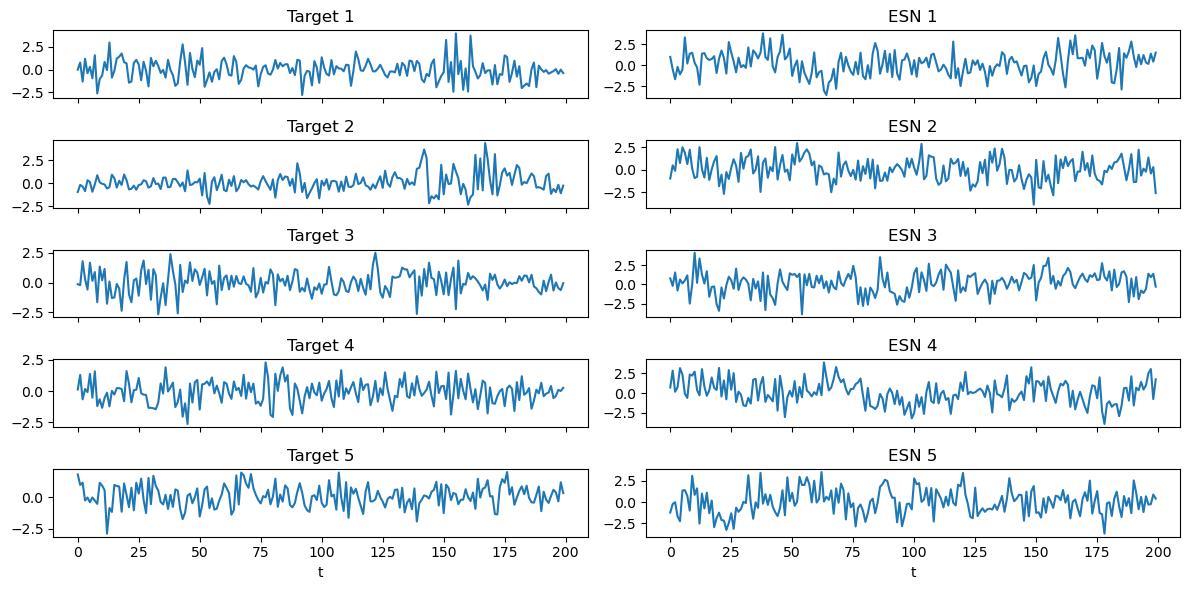

MMD: 0.0666830170741296


In [ ]:
inspection = inspect_run_and_mmd(results=None, kwargs=kwargs, n_examples=5, kernel_mmd = None)   

# Training

In [ ]:
results = train_ESN_MMD(**kwargs)

Noise(kind='normal', params=None)


train:  22%|██▏       | 217/1000 [00:16<00:53, 14.59it/s, avg_k=-.000533, drops=1, loss=-.00103, lr=0.0005] 

LR drop 1/3: lr -> 0.0005


train:  29%|██▉       | 291/1000 [00:23<01:06, 10.71it/s, avg_k=-.000907, drops=2, loss=-.000465, lr=0.00025]

LR drop 2/3: lr -> 0.00025


train:  38%|███▊      | 381/1000 [00:31<00:44, 13.90it/s, avg_k=0.000258, drops=3, loss=0.00104, lr=0.000125]

LR drop 3/3: lr -> 0.000125


train:  55%|█████▌    | 554/1000 [00:49<00:39, 11.24it/s, avg_k=0.000731, drops=3, loss=-.000527, lr=0.000125]

Early stopping at epoch 554 (best avg_20 -0.00173677 at epoch 304, lr_drops_used=3)


# Visualize and analyse results

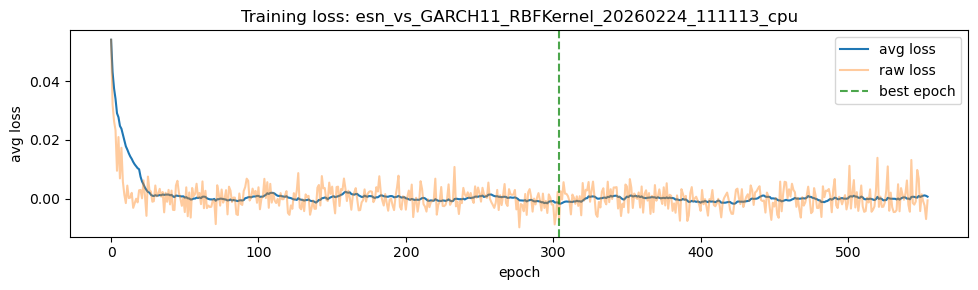

Final average loss: 0.0007
Final loss: -0.0005
Best average loss: -0.0017 at epoch 304


In [ ]:
losses = plot_loss_from_run(results, kwargs, overlay_raw=True, log_scale=False, overlay_lr = True, mark_best_and_drops=True)
print(f"Final average loss: {losses['avg_losses'][-1]:.4f}")
print(f"Final loss: {losses['losses'][-1]:.4f}")
print(f"Best average loss: {losses['best_avg_loss']:.4f} at epoch {losses['best_epoch']}")

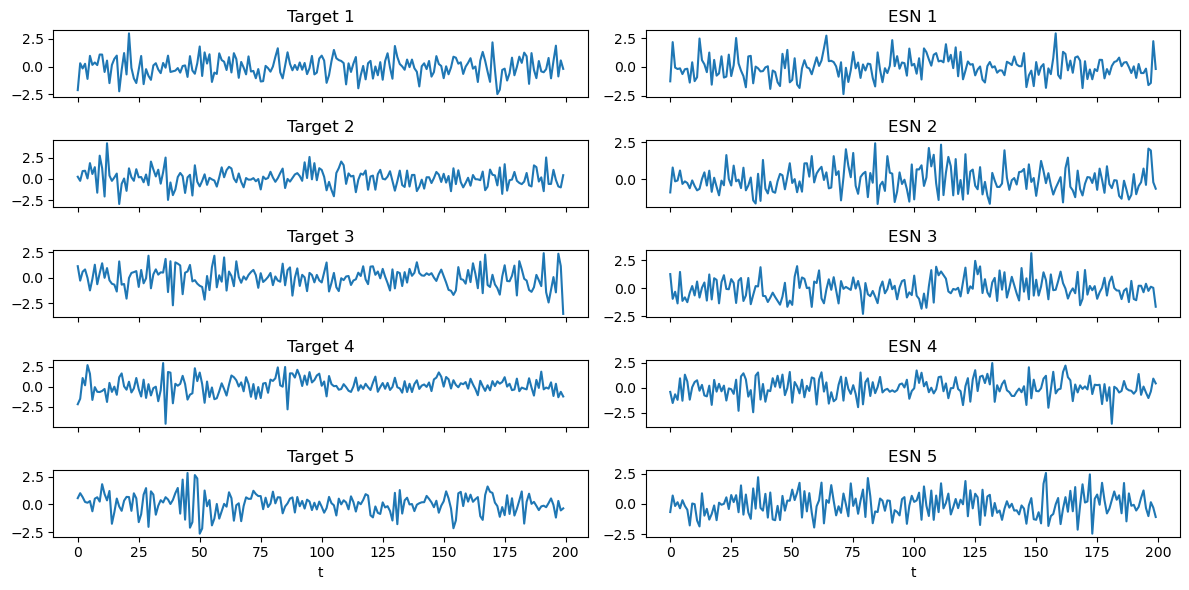

MMD: 0.00031253891296101344


In [ ]:
inspection = inspect_run_and_mmd(results, kwargs, n_examples=5, kernel_mmd = None, use_best=True)   

# ACF analysis

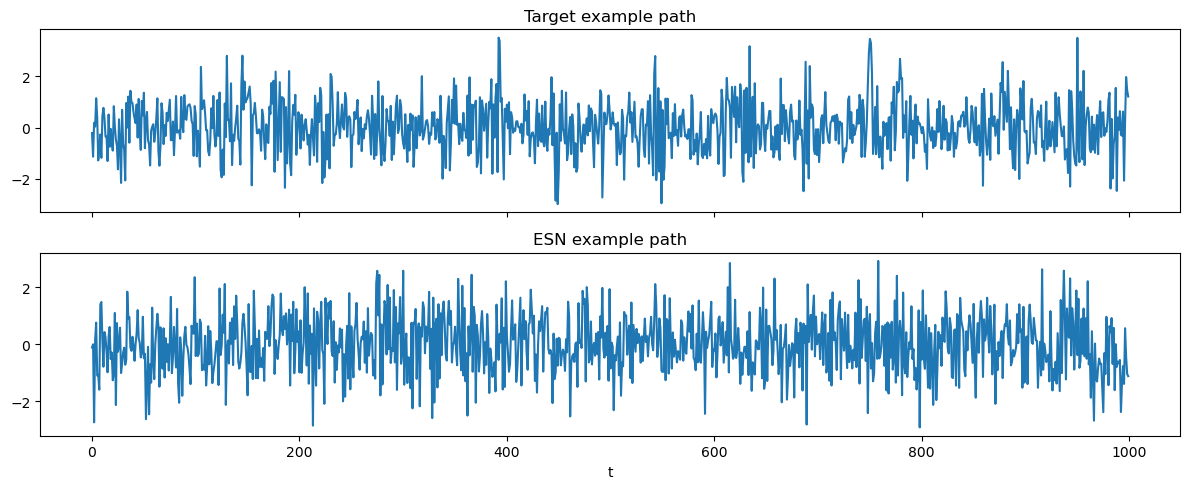

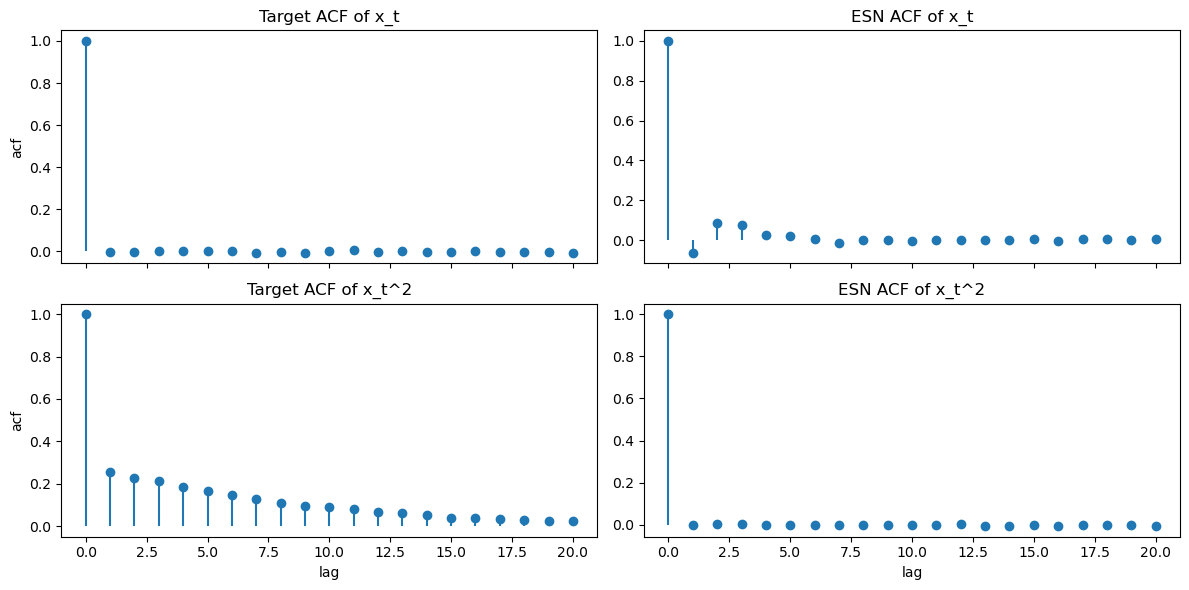

In [ ]:
out = acf_analysis(results, kwargs, T_acf=1000, N_paths=100, lag_acf=20)